# Orientation Mapping Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/10.strain_orientation_mapping_02.ipynb)

This notebook performs disk detection for the AuAgPd nanowire 4D-STEM bullseye experiment. The data has been downsampled for the purposes of the tutorial.

Our goal is to perform automated crystal orientation mapping (ACOM), as described in: <br>
[Automated Crystal Orientation Mapping in py4DSTEM using Sparse Correlation Matching](https://doi.org/10.1017/S1431927622000101)

### Data

[small_AuAgPd_wire_dataset_04.h5](https://drive.google.com/file/d/1OQYW0H6VELsmnLTcwicP88vo2V5E3Oyt/view?usp=sharing) (2.0 GB)

[downsampled_AuAgPd_wire_probe.h5](https://drive.google.com/file/d/17OduUKpxVBDumSK_VHtnc2XKkaFVN8kq/view?usp=sharing)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Alex Rakowski (arakowski@lbl.gov)
- Stephanie Ribet (sribet@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Colin Ophus (cophus@gmail.com)

Experimental data was collected by Alexandra Bruefach (abruefach@berkeley.edu )

### pymatgen

This notebook requires pymatgen.

We use the python package pymatgen for various symmetry calculations of crystals in py4DSTEM. The ACOM module of py4DSTEM can be used without pymatgen, but with substantially reduced functionality. We therefore recommend installing pymatgen if you wish to perform ACOM calculations.

Updated 02/01/2025


In [1]:
%pip install py4DSTEM pymatgen > /dev/null 2>&1

In [2]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


In [3]:
# Get the 4DSTEM dataset and vacuum probe image
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1OQYW0H6VELsmnLTcwicP88vo2V5E3Oyt',
    destination = '/content/',
    filename = 'small_AuAgPd_wire_dataset_04.h5',
    overwrite=True
)
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=17OduUKpxVBDumSK_VHtnc2XKkaFVN8kq',
    destination = '/content/',
    filename = 'downsampled_AuAgPd_wire_probe.h5',
    overwrite=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1OQYW0H6VELsmnLTcwicP88vo2V5E3Oyt
From (redirected): https://drive.google.com/uc?id=1OQYW0H6VELsmnLTcwicP88vo2V5E3Oyt&confirm=t&uuid=e01acfab-524f-481c-9d43-d3b11257ab1e
To: /content/small_AuAgPd_wire_dataset_04.h5
100%|██████████| 2.10G/2.10G [00:25<00:00, 81.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=17OduUKpxVBDumSK_VHtnc2XKkaFVN8kq
To: /content/downsampled_AuAgPd_wire_probe.h5
100%|██████████| 19.0M/19.0M [00:00<00:00, 86.7MB/s]


In [4]:
dirpath = '/content/'
filepath_data = dirpath + 'small_AuAgPd_wire_dataset_04.h5'
filepath_probe = dirpath + 'downsampled_AuAgPd_wire_probe.h5'
filepath_analysis = dirpath + 'AuAgPd_analysis_'

# Load Datasets

In [5]:
# Load the datacubes using py4DSTEM
dataset = py4DSTEM.read(filepath_data, data_id='datacube_0')
dataset_probe = py4DSTEM.read(filepath_probe, data_id='datacube_0')

In [6]:
# Let's add the pixel sizes from the original .dm4 file to this dataset (this step will be automated during data load in the new future)

pixel_size_inv_Ang = 0.021
probe_step_size_Ang = 5.0

# Diffraction space
dataset.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset.calibration.set_Q_pixel_units('A^-1')
dataset_probe.calibration.set_Q_pixel_size(pixel_size_inv_Ang)
dataset_probe.calibration.set_Q_pixel_units('A^-1')

# Real space
dataset.calibration.set_R_pixel_size(probe_step_size_Ang)
dataset.calibration.set_R_pixel_units('A')


In [7]:
# Calculate these images:
#     -max diffraction pattern from dataset
#     -mean diffraction pattern from dataset
#     -mean diffraction pattern from probe
dataset.get_dp_max();
dataset.get_dp_mean();
dataset_probe.get_dp_mean();

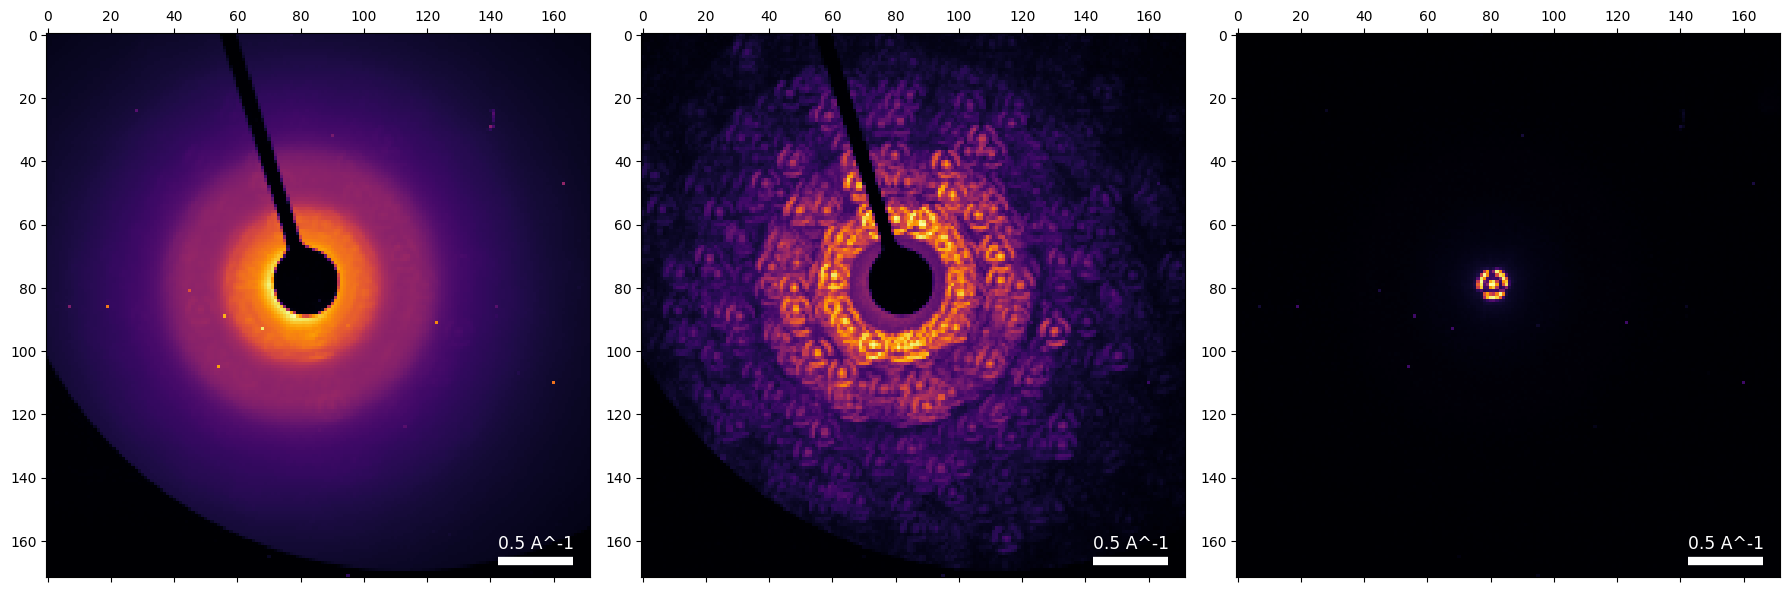

In [8]:
py4DSTEM.show(
    [
        dataset.tree('dp_mean'),
        dataset.tree('dp_max'),
        dataset_probe.tree('dp_mean'),
    ],
    vmax=1,
    power=0.5,
    cmap='inferno',
)

# Virtual images

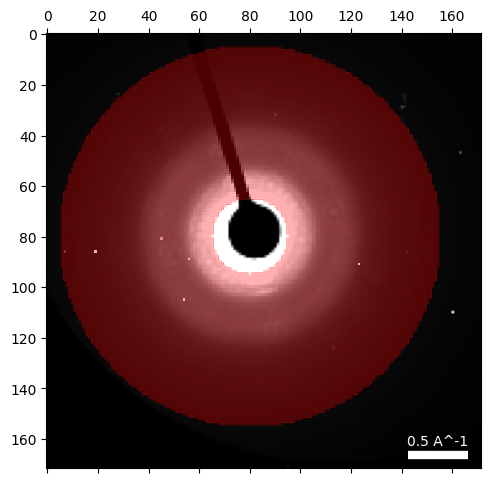

100%|██████████| 8866/8866 [00:00<00:00, 13225.47it/s]


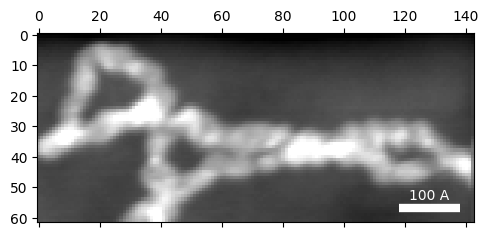

In [9]:
# Create an annular dark field (ADF) virtual detector using user-chosen values:
center = (80,80)
radii = (15,75)

# Plot the ADF detector
dataset.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    )
)

# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = ((center),radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.show(
    dataset.tree('dark_field'),
)

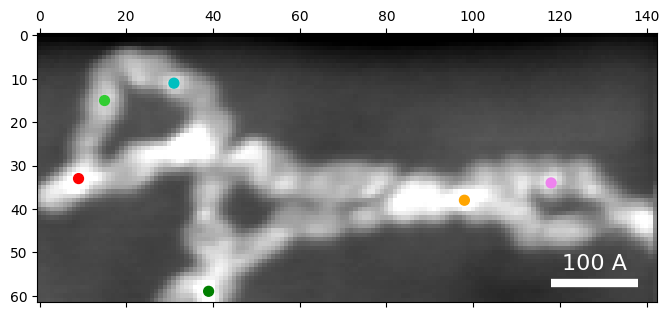

In [10]:
# Choose some diffraction patterns to use for parameter tuning

rxs = 33,15,11,59,38,34
rys = 9,15,31,39,98,118,
colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dataset.tree('dark_field'),
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Construct Probe Template

In [11]:
# Align the probe images (this is not necessary if you don't scan while recording a vacuum probe).
# Note that we need to use a low threshold to make this function work with a bullseye probe.

probe_align = dataset_probe.get_vacuum_probe(
    threshold = 0.02,
    align = True,
)


100%|██████████| 79/79 [00:00<00:00, 94.61it/s]


In [12]:
probe_semiangle, probe_qx0, probe_qy0 = dataset_probe.get_probe_size(
    thresh_lower = 0.02,
    thresh_upper = 0.04,
    figsize = (4,4),
)

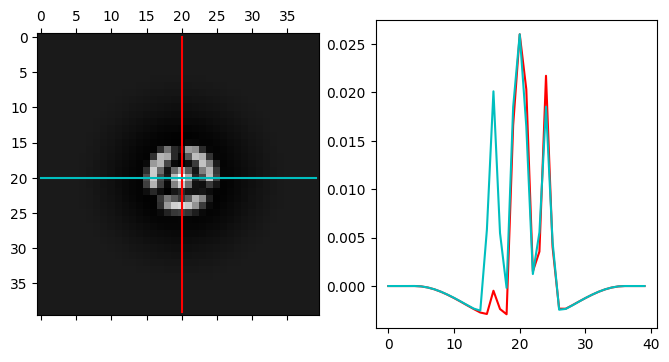

In [13]:
# Construct a probe template to use as a kernel for correlation disk detection
probe_semiangle = 4
probe_kernel = probe_align.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 0.0, probe_semiangle * 4.0),
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_align.kernel,
    R=20,
    L=20,
    W=1,
    figsize = (8,4),
)

# Disk detection

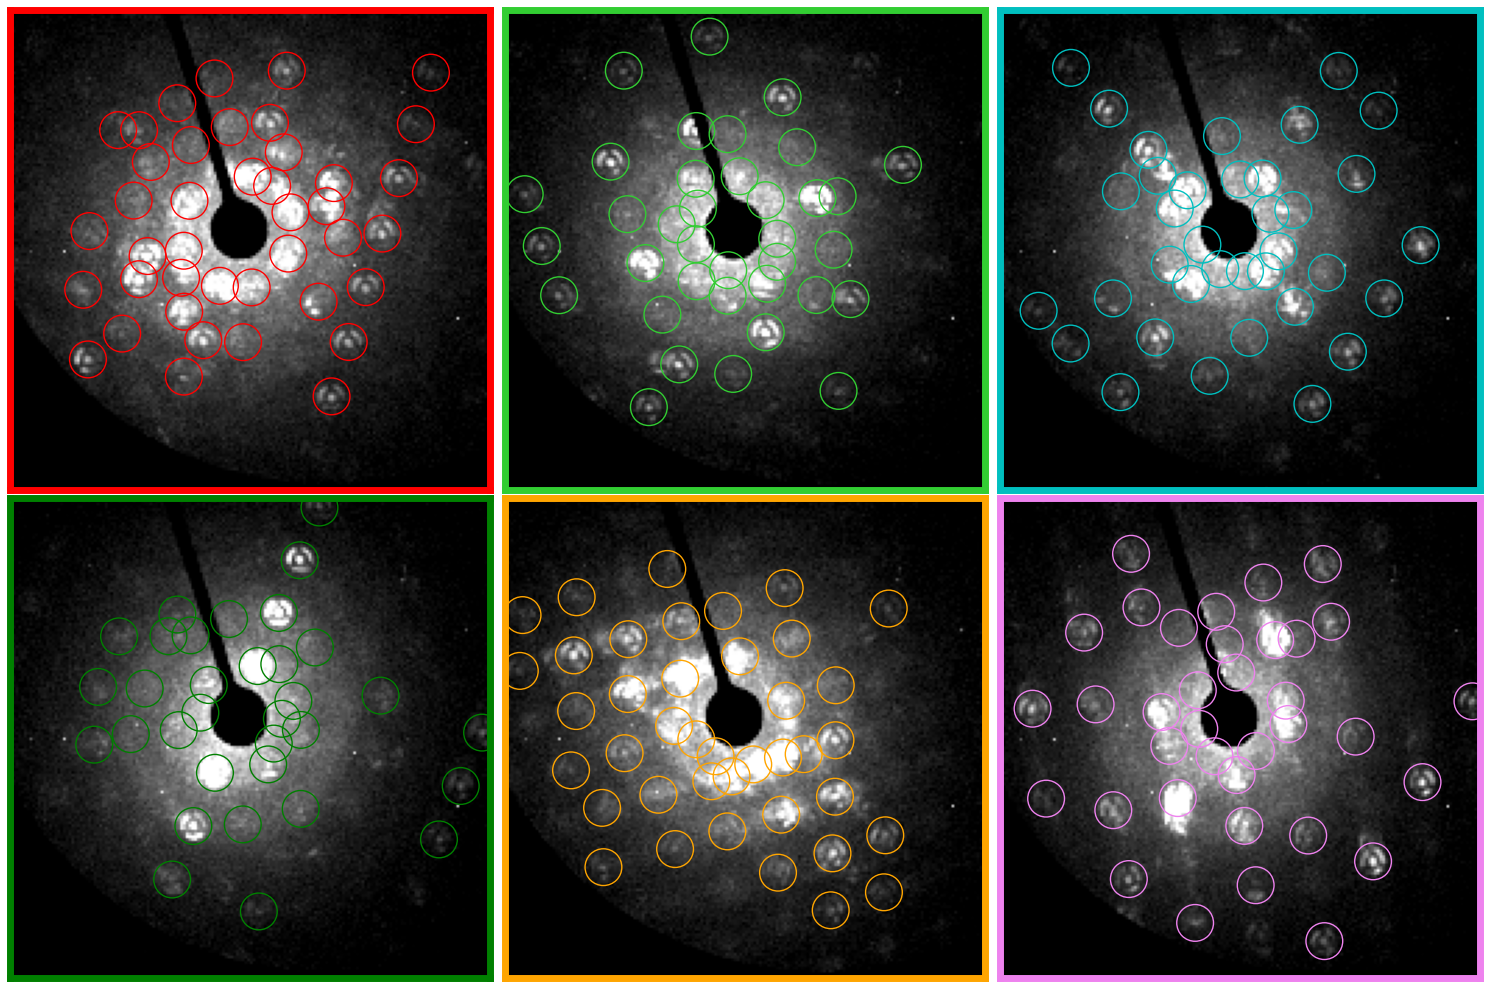

In [14]:
# Test parameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

# parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 10,
    'minPeakSpacing': 8,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2,
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=10,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [15]:
# Find all Bragg peaks
# Note that here we have used "poly" disk detection, which is much faster, but less accurate.
# We do not need extremely precise peak locations to perform an ACOM analysis.

bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████| 8.87k/8.87k [01:10<00:00, 126DP/s]


In [16]:
# Save Bragg disk positions
filepath_braggdisks_raw = filepath_analysis + 'braggdisks_raw.h5'

py4DSTEM.save(
    filepath_braggdisks_raw,
    bragg_peaks,
    mode='o',
)

100%|██████████| 8866/8866 [00:01<00:00, 4654.47it/s]


# Remove false positives due to beamstop

Many 4DSTEM experiments require a beamstop to prevent damage or saturation on the detector.  In the above experiment, the beamstop has produced a ring of false positives around the center, and along the beamstop arm.  Here, we filter and remove them.

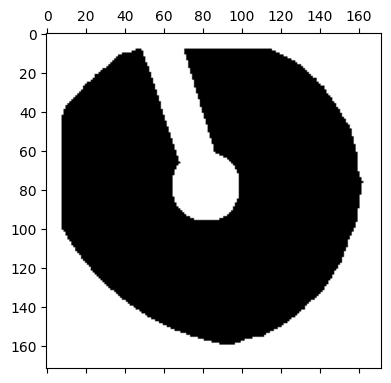

In [17]:
# First, generate a mask of the beamstop, plot it
dataset.get_beamstop_mask(
    threshold = 0.25,
    distance_edge = 8,
    # include_edges=False,
);

py4DSTEM.show(
    dataset.tree("mask_beamstop"),
    intensity_range='absolute',
    vmin=0,
    vmax=1,
    figsize = (4,4),
)

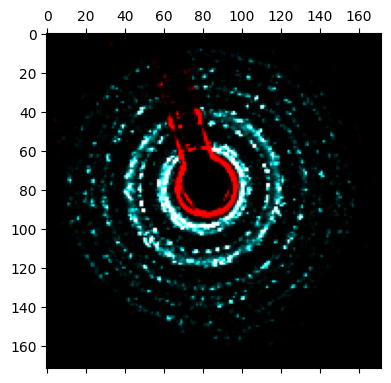

In [18]:
# Apply the mask to the raw bragg peaks
bragg_peaks_masked = bragg_peaks.mask_in_Q(
    dataset.tree("mask_beamstop").data,
)

# Create a bragg vector map (2D histogram of all detected bragg peaks) for both raw and masked Bragg peaks
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')

# Plot a comparison image between the original and masked bragg vector map
py4DSTEM.show(
    [
        bragg_vector_map,
        bragg_vector_map_masked,
    ],
    combine_images = True,
    figsize = (4,4),
)

In [19]:
# Save masked Bragg peaks
filepath_braggdisks_masked = filepath_analysis + 'braggdisks_masked.h5'
py4DSTEM.save(
    filepath_braggdisks_masked,
    bragg_peaks_masked,
    mode='o',
)

100%|██████████| 8866/8866 [00:01<00:00, 5302.47it/s]


# Bragg peak calibration - centering and elliptical distortion

In [20]:
# # Reload Bragg peaks if needed
# filepath_braggdisks_masked = filepath_analysis + 'braggdisks_masked.h5'
# py4DSTEM.print_h5_tree(filepath_braggdisks_masked)

In [ ]:
# Uncomment to load the bragg peaks at this stage
# bragg_peaks_masked = py4DSTEM.read(
#     filepath_braggdisks_masked,
# )
# bragg_peaks_masked

In [21]:
# Generate a histogram of all bragg peaks detected
bragg_vector_map_masked = bragg_peaks_masked.get_bvm(mode='raw')

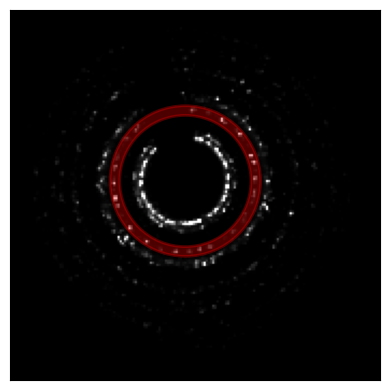

In [22]:
# let's position a
center_guess = (79,81)
q_range = (30.5,35.0)

py4DSTEM.show(
    bragg_vector_map_masked,
    intensity_range='absolute',
    vmin=0,
    vmax=1e4,
    annulus={
        'center':center_guess,
        'radii': q_range,
        'fill':True,
        'color':'r',
        'alpha':0.3
    },
    figsize = (4,4),
    ticks = False,
)

In [ ]:
bragg_peaks_masked.fit_p_ellipse?

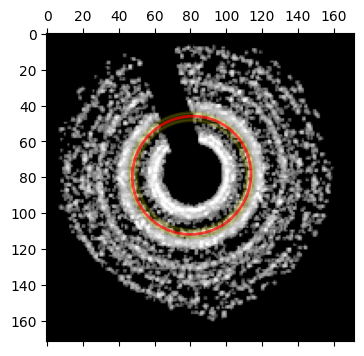

In [23]:
p_ellipse = bragg_peaks_masked.fit_p_ellipse(
    bragg_vector_map_masked,
    center = center_guess,
    fitradii = q_range,
    figsize = (4,4),
    returncalc = True,
)

In [24]:
# Use the fitted center coordinate too
bragg_peaks_masked.calibration.set_origin(p_ellipse[:2])

# Rotation calibration

In [25]:
# The rotation of this dataset was determined independently (outside the scope of this notebook)
theta = -146.4067
flip = True

In [26]:
bragg_peaks_masked.calibration.set_QR_rotflip((theta, flip))
# bragg_peaks_masked.setcal()

In [27]:
bragg_peaks_masked.calstate

{'center': True, 'ellipse': True, 'pixel': True, 'rotate': True}

# Pixel size calibration

In [28]:
# Define gold structure using manual input of the crystal structure with known lattice parameter

a_lat = 4.08
atom_num = 79
k_max = 1.5


pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos,
    atom_num,
    a_lat)
# Calculate structure factors
crystal.calculate_structure_factors(k_max)

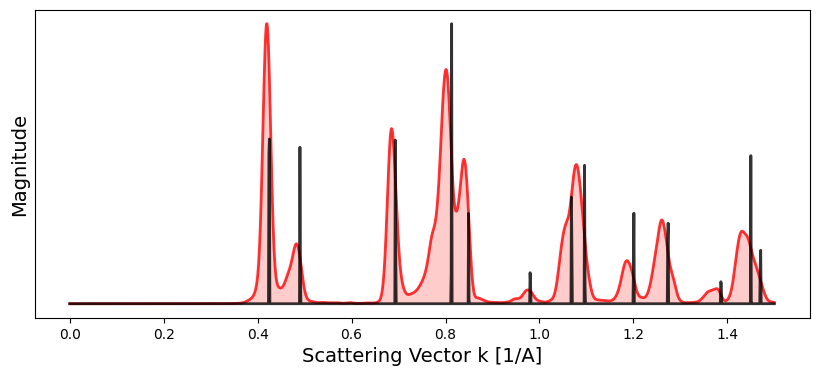

In [29]:
# Compare measured diffraction pattern with reference crystal structure
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
)

   Initial pixel size = 0.021 A^-1
Calibrated pixel size = 0.02127316 A^-1


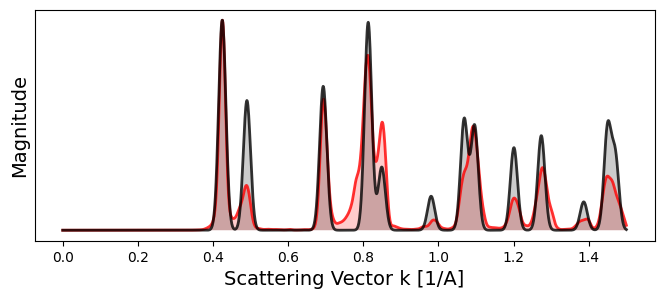

In [30]:
# Display the current pixel size
print('   Initial pixel size = ' + \
    str(np.round(bragg_peaks_masked.calibration.get_Q_pixel_size(),8)) + \
    ' ' + bragg_peaks_masked.calibration.get_Q_pixel_units())

# Calibrate pixel size
bragg_peaks_cali = crystal.calibrate_pixel_size(
    bragg_peaks = bragg_peaks_masked,
    bragg_k_power = 2.0,
    plot_result = True,
    figsize = (8,3),
)

In [31]:
# Save calibrated Bragg peaks
filepath_braggdisks_cali = filepath_analysis + 'braggdisks_cali.h5'
py4DSTEM.save(
    filepath_braggdisks_cali,
    bragg_peaks_cali,
    mode='o',
)

100%|██████████| 8866/8866 [00:01<00:00, 7638.49it/s]


# Automated Crystal Orientation Mapping

In [32]:
# # Reload Bragg peaks if needed
# filepath_braggdisks_cali = filepath_analysis + 'braggdisks_cali.h5'
# py4DSTEM.print_h5_tree(filepath_braggdisks_cali)

In [ ]:
# Uncomment to reload the calibrated Bragg peaks
# bragg_peaks_cali = py4DSTEM.read(
#     filepath_braggdisks_cali,
# )
# bragg_peaks_cali

In [34]:
# Define gold structure using manual input of the crystal structure again if needed
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos,
    atom_num,
    cell
    )

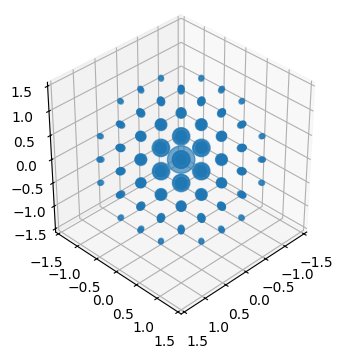

In [35]:
# Calculate and plot gold structure factors
k_max = 1.5

crystal.calculate_structure_factors(
    k_max,
)

crystal.plot_structure_factors(
    zone_axis_lattice=[1,1,1],
    figsize = (4,4),
)

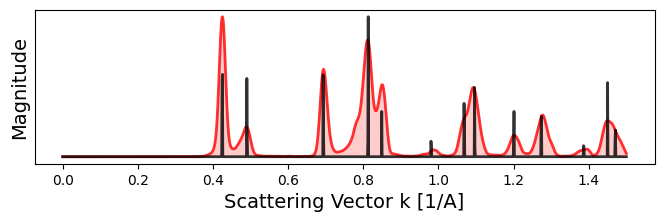

In [36]:
crystal.plot_scattering_intensity(
    bragg_peaks = bragg_peaks_cali,
    bragg_k_power = 2.0,
    figsize = (8,2),
)

100%|██████████| 8866/8866 [00:00<00:00, 11309.34it/s]


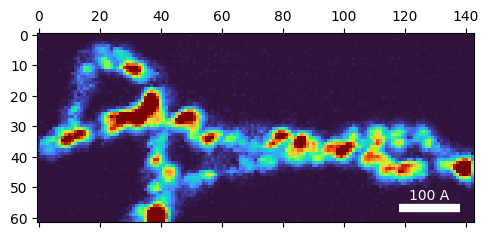

In [37]:
# Make and plot a virtual dark field image to find the non-vacuum probe positions
im_DF = bragg_peaks_cali.get_virtual_image(
    mode = 'annular',
    geometry=((),(0.3,0.6)),
)

py4DSTEM.show(
    im_DF,
    cmap='turbo',
)

In [38]:
# # Create an orientation plan for gold using pymatgen

crystal.orientation_plan(
    zone_axis_range = 'auto',
    angle_step_zone_axis = 2.0,
    #
    # angle_step_zone_axis = 0.5,
    # angle_coarse_zone_axis = 2.0,
    # angle_refine_range = 2.0,
    #
    angle_step_in_plane = 5.0,
    accel_voltage = 300e3,
#     CUDA = True,
#     intensity_power = 0.5,
#     intensity_power = 0.125,
#     radial_power = 2.0,
    # corr_kernel_size = 0.12,
    # tol_peak_delete = 0.08,
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 406/406 [00:00<00:00, 5560.65 zone axes/s]


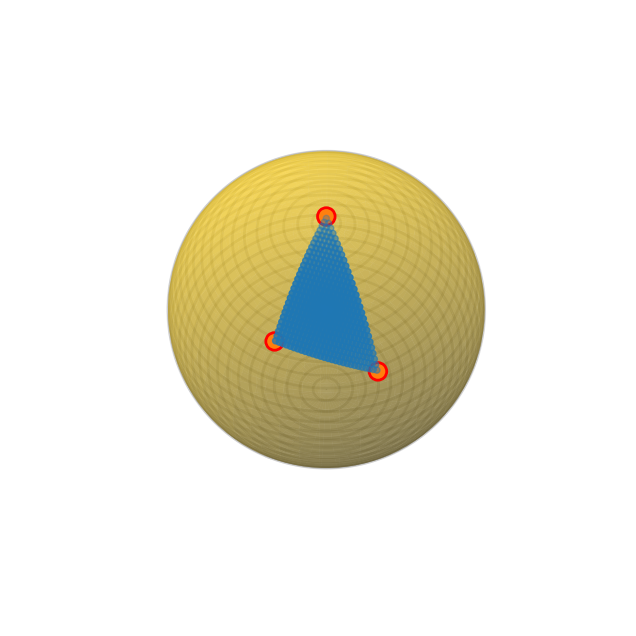

In [39]:
crystal.plot_orientation_zones(
    plot_zone_axis_labels = False,
)

Best fit lattice directions: z axis = ([0.395 0.481 0.783]), x axis = ([0.115 0.561 0.82 ]), with corr value = 10.659
Best fit lattice directions: z axis = ([0.25  0.662 0.706]), x axis = ([0.186 0.514 0.837]), with corr value = 6.195
Best fit lattice directions: z axis = ([0.094 0.614 0.784]), x axis = ([0.14  0.621 0.771]), with corr value = 6.166


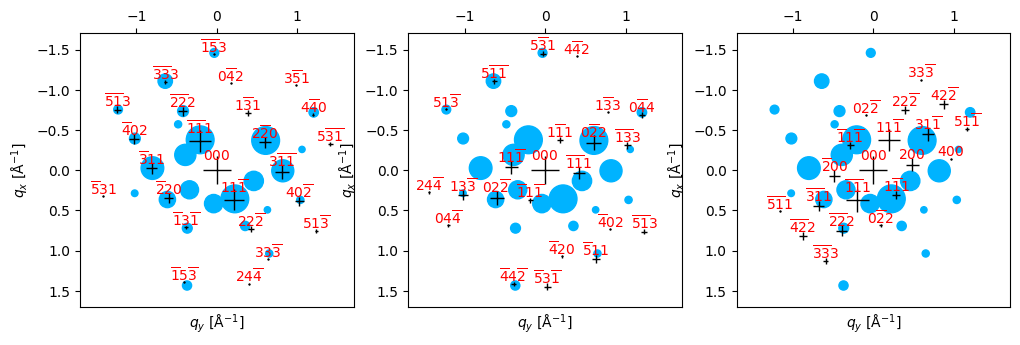

In [40]:
# Test matching on some probe positions
sigma_compare = 0.03  # Excitation error for the simulated diffraction patterns
figsize = (12,4)

xind, yind = 34, 12
xind, yind = 40, 93
# xind, yind = 30, 40

# plotting parameters
plot_params = {
    'scale_markers': 2000,
    'scale_markers_compare': 2,
    'plot_range_kx_ky': crystal.k_max+0.2,
    'min_marker_size': 2,
    'max_marker_size': 400,
}

# Find best fit orientations
orientation  = crystal.match_single_pattern(
    bragg_peaks_cali.cal[xind,yind],
    num_matches_return = 3,
    verbose = True,
)

# Simulated bragg peaks from best fit orientations
peaks_fit_0 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)
peaks_fit_1 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=1,
    sigma_excitation_error=sigma_compare)
peaks_fit_2 = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=2,
    sigma_excitation_error=sigma_compare)

# plot comparisons
fig,ax = plt.subplots(1,3,figsize=figsize)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_0,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[0]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_1,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[1]]),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    peaks_fit_2,
    bragg_peaks_compare=bragg_peaks_cali.cal[xind,yind],
    **plot_params,
    input_fig_handle=(fig,[ax[2]]),
)

In [41]:
# Some probe positions have up to 3 reasonable looking matches, so we could set num_matches_return = 3.

# For now we will use num_matches_return = 1 for a faster calculation for this tutorial.

In [42]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks_cali,
    num_matches_return = 1,
    min_number_peaks = 3,
)

Matching Orientations: 100%|██████████| 8866/8866 [02:37<00:00, 56.45 PointList/s]


# Plot the resulting orientation map

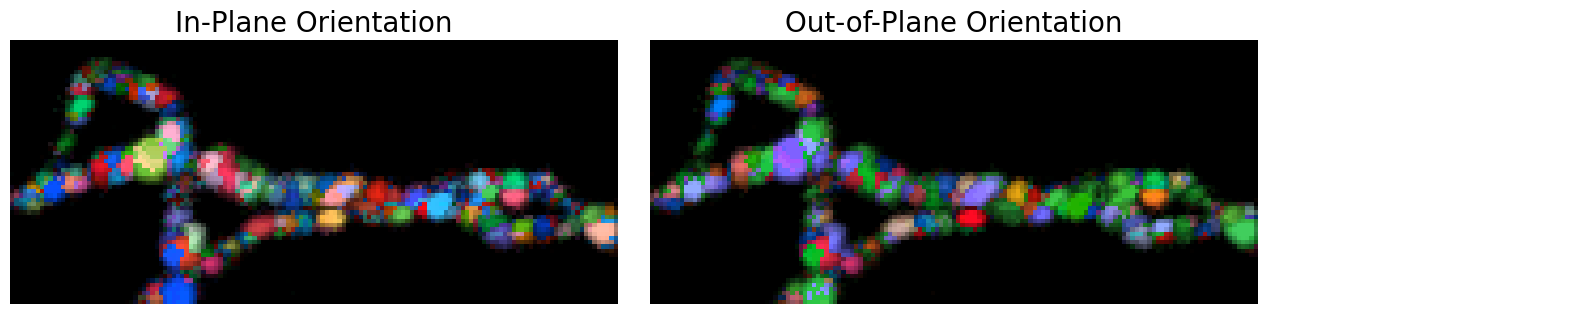

In [43]:
# plot orientation map
images_orientation = crystal.plot_orientation_maps(
    orientation_map,
    orientation_ind=0,
    corr_range = np.array([1,4]),
    camera_dist = 10,
    show_axes = False,
    show_legend = False,
)